# Final Assignment

Sancho Luijten Perona

## 0. Importing and loading in data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as sps
import scipy.optimize as spopt
import scipy.integrate as spint

In [2]:
grb1 = np.genfromtxt('Data_grb1.txt')
grb2 = np.genfromtxt('Data_grb2.txt')
grb3 = np.genfromtxt('Data_grb3.txt')
grb4 = np.genfromtxt('Data_grb4.txt')

## 1. Shape of distributions

*Approach:* To visualize the shape of the distributions, I will create a function that plots the histograms of the energies for each event. The histograms will be rebinned to contain a minimum amount of counts per bin, in order to clean up the high-energy end of the histogram. Furthermore, instead of counts, count density will be plotted. Eventually, I fit a power law to all the data sets, in order to see whether the power law behaviour is true.

In [3]:
def histrebin(mininbin, counts, edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.'''
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

def energy_hist(grb, mincounts=20, plot_flag=False):
    '''Plots rebinned energy density histogram of given grb data.'''
    en_counts, en_edges = np.histogram(grb[:,1], bins=100, range=[10,200], density=False)
    en_counts, en_edges = histrebin(mincounts, en_counts, en_edges)
    bwidths = np.diff(en_edges)
    en_bins = (en_edges[:-1]+en_edges[1:])/2.
    cdens = en_counts/bwidths
    cdens_err = np.sqrt(en_counts)/bwidths # 1-sigma error is sqrt(counts)
    
    if plot_flag:
        plt.figure(figsize=(7,4))
        plt.errorbar(en_bins, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
        plt.yscale('log')
        plt.xscale('log')
        plt.title('Energy distribution for GRB event')
        plt.xlabel('Energy [GeV]')
        plt.ylabel('Count density [GeV$^{-1}$]')
        plt.show()
    else:
        return(en_bins, en_edges, cdens, cdens_err)

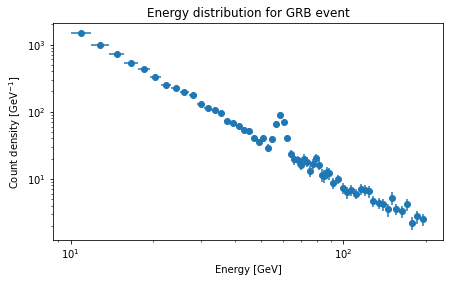

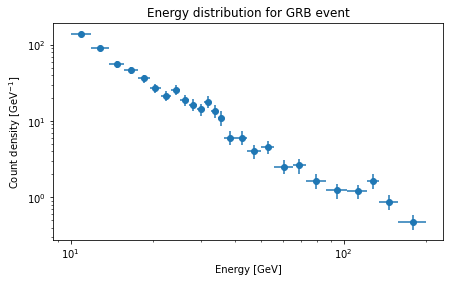

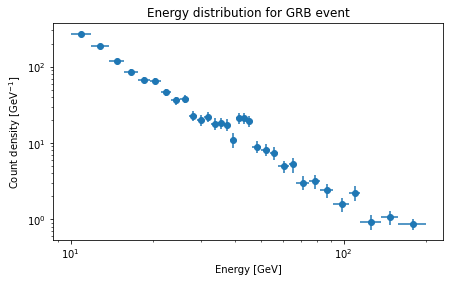

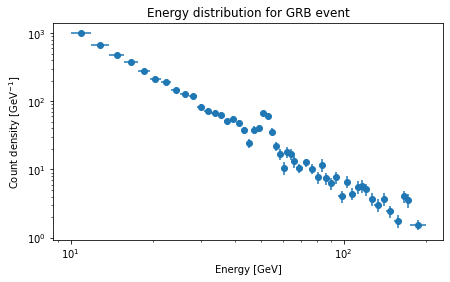

In [4]:
energy_hist(grb1, plot_flag=True)
energy_hist(grb2, plot_flag=True)
energy_hist(grb3, plot_flag=True)
energy_hist(grb4, plot_flag=True)

*Conclusion:* Here we see that the energy distribution seems to follow a power law with a negative exponent. However, some possible emission lines can also be spotted by eye. For GRB1, there seems to be a feature at ~60GeV. GRB2 doesn't show any obvious emission lines. GRB3 has a possible line at ~40GeV. Lastly, GRB4 shows a possible feature at ~50GeV.

In order to confirm these suspicions, I will fit a power law over the four bursts.

In [5]:
def model_pl(E_arr, *parm):
    '''Cut-off power law model'''
    N_0   = parm[0]
    Gamma = parm[1]
    bckg = 0.01 * 40 # background in [GeV^-1]
    N_cont = N_0*E_arr**(-Gamma) + bckg
    return N_cont

def model_int_cf(ebins, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.'''
    i = 0
    ymod = np.zeros(len(ebins)-1)
    model = model_pl
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm), ebins[i], ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

In [6]:
def fit_pl(grb, p0):
    '''Fit powerlaw and plot the results, printing the coefficients obtained, and returning minimum chi2.'''
    # calculate histogram values of grb data
    en_bins, en_edges, cdens, cdens_err = energy_hist(grb)
    bwidths = np.diff(en_edges)
    # fit pl model to the data
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda en_bins, *parm: model_int_cf(en_edges, *parm),
                                            en_bins, cdens, p0, sigma=cdens_err)
    # print fit results
    err = np.sqrt(np.diag(ml_cfcovar))
    print("N_0   = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
    print("Gamma = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
    # for pl+gaussian
    if len(p0) == 4:
        print("N_tot  = " + str(ml_cfpars[2]) + " +/- " + str(err[2]))
        print("E_cent = " + str(ml_cfpars[3]) + " +/- " + str(err[3]))
    minchisq = np.sum(((cdens - model_int_cf(en_edges, *ml_cfpars))/cdens_err)**2.)
    print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
    print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))
    
    
    # plot data + fit
    cdens_model = model_int_cf(en_edges, *ml_cfpars)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,5),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(en_bins, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
    ax1.hist(en_bins, bins=en_edges, weights=cdens_model, density=False, histtype='step')
    ax2.errorbar(en_bins, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='o')
    ax2.set_xlabel("Energy (GeV)", fontsize=16)
    ax1.set_ylabel("Counts/Gev", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(10,200)
    plt.show()
    return minchisq, ml_cfpars

N_0   = 382053.7918795494 +/- 32745.307932538683
Gamma = 2.3332963763514116 +/- 0.028097488184019272
Minimum Chi-squared = 228.49594782205412 for 60 d.o.f.
The goodness of fit is: 1.734960415251243e-21


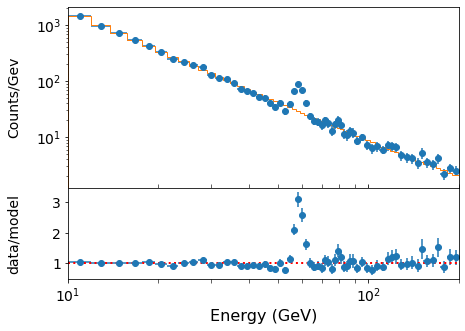

N_0   = 29881.65419449376 +/- 5140.146029815102
Gamma = 2.2875113386255412 +/- 0.0570303015550225
Minimum Chi-squared = 28.41680900106895 for 24 d.o.f.
The goodness of fit is: 0.2428528238351879


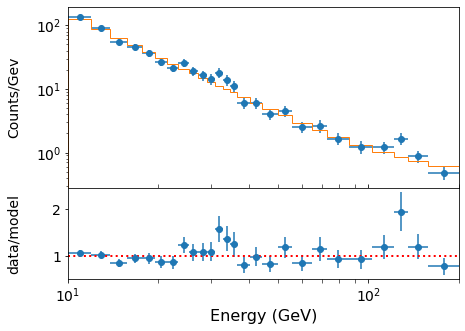

N_0   = 68577.50798489398 +/- 9968.644735648919
Gamma = 2.33900758368909 +/- 0.04818418196765517
Minimum Chi-squared = 52.13733470456628 for 30 d.o.f.
The goodness of fit is: 0.007361043411428764


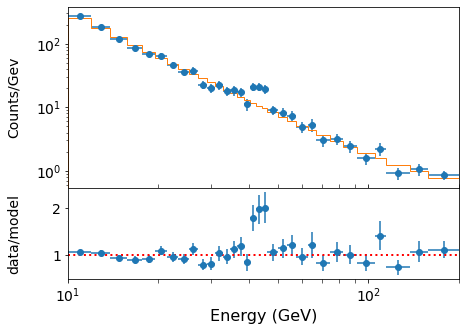

N_0   = 268531.7220560659 +/- 26444.358707853193
Gamma = 2.348627713921714 +/- 0.03239083613822148
Minimum Chi-squared = 167.19439088915033 for 50 d.o.f.
The goodness of fit is: 1.5075187408301372e-14


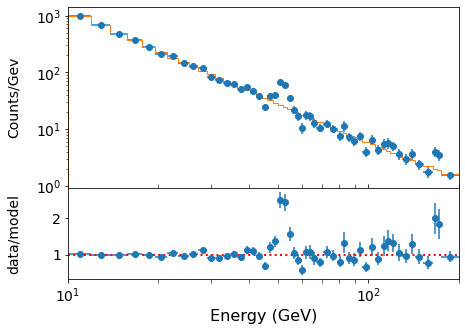

In [7]:
chi2_free1, _ = fit_pl(grb1, [40000, 2.1])
chi2_free2, _ = fit_pl(grb2, [40000, 2.1])
chi2_free3, _ = fit_pl(grb3, [40000, 2.1])
chi2_free4, _ = fit_pl(grb4, [40000, 2.1])

*Conclusion:* From the fits, we can confirm that the energies follow a power law. Furthermore, on the data/model part of the plot, emission features can be seen ont the 1st, 3rd and 4th GRB, as mentioned earlier.

To gain more information on these emission lines, I will modify the power law function to contain a gaussian emission feature, and fit the data again, using the new model. The goodness of fit should improve if these features are real.

In [8]:
def gaussian_pl(E_arr, *parm):
    '''Power law model with an additional gaussian peak'''
    N_0    = parm[0]
    Gamma  = parm[1]
    N_tot  = parm[2]
    E_cent = parm[3]
    bckg = 0.01 * 40 # background in [GeV^-1]
    sigma  = 2 # sigma fixed at 2GeV for the detector
    
    N_gauss = N_tot/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(E_arr-E_cent)**2/(sigma)**2)
    N_cont = N_0*E_arr**(-Gamma) + bckg

    return N_cont + N_gauss

# redefine bin integration function for gaussian_pl model
def model_int_cf(ebins, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.'''
    i = 0
    ymod = np.zeros(len(ebins)-1)
    model = gaussian_pl
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm), ebins[i], ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

N_0   = 416748.73103873286 +/- 17405.542472708203
Gamma = 2.3660669097148466 +/- 0.013853827394851073
N_tot  = 321.64091039532735 +/- 21.979564653921354
E_cent = 58.787921267946544 +/- 0.1717167435547206
Minimum Chi-squared = 48.6359546533786 for 58 d.o.f.
The goodness of fit is: 0.8046550783822469


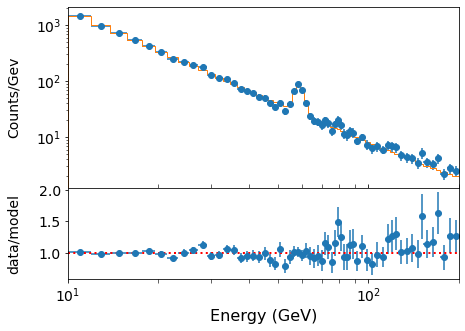

N_0   = 32413.78307378948 +/- 5245.071545156611
Gamma = 2.321865606268145 +/- 0.05458000536679083
N_tot  = 31.033910354377657 +/- 10.897495810002976
E_cent = 32.38093259604947 +/- 0.9164472497659375
Minimum Chi-squared = 20.735069081172124 for 22 d.o.f.
The goodness of fit is: 0.5371589507226497


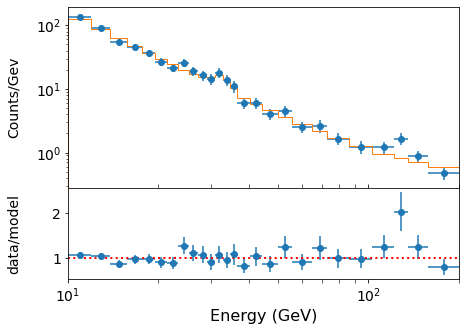

N_0   = 76509.3736734939 +/- 8631.077617298404
Gamma = 2.3816317166711305 +/- 0.03800874776551516
N_tot  = 64.09600850450359 +/- 12.169110949761953
E_cent = 43.53618750873849 +/- 0.49933776243078665
Minimum Chi-squared = 26.18887571272554 for 28 d.o.f.
The goodness of fit is: 0.5626632636784586


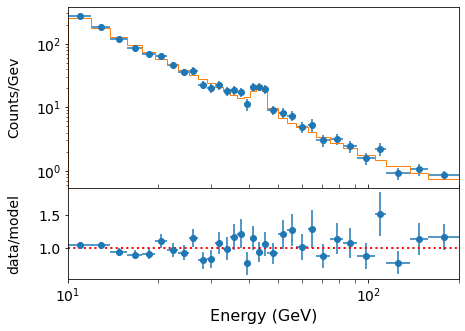

N_0   = 293264.2676423014 +/- 19038.743023621446
Gamma = 2.3824538004616196 +/- 0.021634000698417696
N_tot  = 212.58600184030058 +/- 24.20683218313399
E_cent = 51.74937877955948 +/- 0.2840339779024931
Minimum Chi-squared = 64.0676554554637 for 48 d.o.f.
The goodness of fit is: 0.06028432760669831


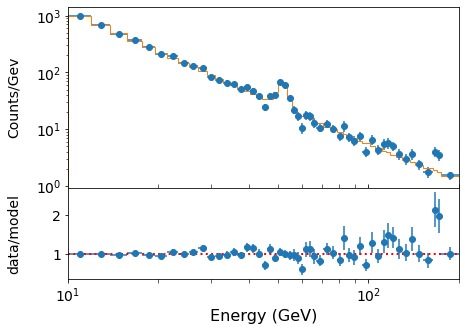

In [9]:
chi2_constrained1, e_fit_pars1 = fit_pl(grb1, [359000, 2.31, 50, 60])
chi2_constrained2, e_fit_pars2 = fit_pl(grb2, [19100, 2.12, 10, 30])
chi2_constrained3, e_fit_pars3 = fit_pl(grb3, [52000, 2.24, 50, 40])
chi2_constrained4, e_fit_pars4 = fit_pl(grb4, [242970, 2.31, 50, 50])

*Conclusion:* When fitting the gaussian feature over the four bursts, by eye the fit seems to improve. The power law component of the fit does not significantly change from the fit performed without the gaussian. For GRBs 1, 3 and 4, the central energy $E_{cent}$ is well determined with a small error. For GRB 2, where no peak was obvious, the fit finds a small emission feature at $E_{cent}=32.1GeV$, with a larger error than the rest, however.

To test whether adding the emission line improves the model significantly, I will apply Wilks' theorem. The teorem tells us that $\Delta\chi^2$ going from a less constrained model (power law), to a more constrained model (power law+gaussian), is distributed as $\chi_m^2$, where $m$ is the number of additional constraints of the new model. The number of free parameters is not 2, as it may seem at first. The line energy, $E_{cent}$ is not a nestable parameter, as the likelihood does not smoothly change if we change the position of the sharp feature. Thus, for our case, Wilks' theorem reads as $\Delta\chi^2\sim\chi_1^2$. The null hypothesis $H_0$ states that the emission line does not exist. In other words, $N_{tot}=0$. The function wilks_theorem returns the p-value on this hypothesis.

In [10]:
def wilks_theorem(chi2_free, chi2_constrained, df=1):
    '''Test for significance of improvement when constraining a model using Wilks' theorem.'''
    del_chi2 = chi2_free-chi2_constrained
    return sps.chi2.sf(del_chi2,df=df)

pval1 = wilks_theorem(chi2_free1, chi2_constrained1)
pval2 = wilks_theorem(chi2_free2, chi2_constrained2)
pval3 = wilks_theorem(chi2_free3, chi2_constrained3)
pval4 = wilks_theorem(chi2_free4, chi2_constrained4)

print("p-value for our delta-chi2 on grb1: ",pval1)
print("p-value for our delta-chi2 on grb2: ",pval2)
print("p-value for our delta-chi2 on grb3: ",pval3)
print("p-value for our delta-chi2 on grb4: ",pval4)

p-value for our delta-chi2 on grb1:  5.199834876712298e-41
p-value for our delta-chi2 on grb2:  0.005578235912684129
p-value for our delta-chi2 on grb3:  3.506552387367923e-07
p-value for our delta-chi2 on grb4:  3.1437978058635925e-24


Since we did not initially expect the lines to be where they are, we also have to apply the Bonferroni correction to the p-value. What this does, is take into account the number of trials we hypothetically conducted while looking for the line by eye. We obtain the probability that, having carried out $k$ trials, we would have found the observed $p$-value by chance. To do this, we consider a binomial distribution, $p(x|n,\theta)=(1-\theta)^n$ with no successes, $x=0$ and $n=k$, $\theta=p$. The result is the p-value for not finding a peak, and we want the $p$-value of finding a peak. Thus we subtract the result from 1 to obtain the final corrected $p$-value.

In [11]:
def bonferroni_correction(p_val):
    '''Simple Bonferroni correction of given p_val. To avoid floating point precision problems,
    for extremely small p_vals I use the Taylor expansion as an approximation.'''
    k = np.log10(20)/np.log10(1.5)
    new_p = 1 - (1 - p_val)**k if p_val > 1e-10 else k*p_val
    return new_p
    
new_pval1 = bonferroni_correction(pval1)
new_pval2 = bonferroni_correction(pval2)
new_pval3 = bonferroni_correction(pval3)
new_pval4 = bonferroni_correction(pval4)

print("The Bonferroni corrected p-value for our delta-chi2 on grb1:", new_pval1)
print("The Bonferroni corrected p-value for our delta-chi2 on grb2:", new_pval2)
print("The Bonferroni corrected p-value for our delta-chi2 on grb3:", new_pval3)
print("The Bonferroni corrected p-value for our delta-chi2 on grb4:", new_pval4)

The Bonferroni corrected p-value for our delta-chi2 on grb1: 3.841838137441698e-40
The Bonferroni corrected p-value for our delta-chi2 on grb2: 0.040487114546545744
The Bonferroni corrected p-value for our delta-chi2 on grb3: 2.5907729616081454e-06
The Bonferroni corrected p-value for our delta-chi2 on grb4: 2.3227588170278247e-23


Here the number of trials is estimated by taking the range of logarithmic energies, and dividing it by the width of the possible peak, dictated by the instrument at (1.5GeV).

*Conclusion:* For GRBs 1 and 4, the addition of the gaussian is extremely significant. For GRB 3, although not so high, the constraining of the model is also significant to the $4-\sigma$ level. The same cannot be said about GRB 2. Hence, $H_0$ can be rejected at the $4-\sigma$ confidence level for GRBs 1, 3 and 4, but it can't be rejected for GRB 2.

## 2. Estimating redshifts

$E(z)=E_0(1+z)^{-1}$

*Approach:* Use above equation to find $E_0$, using known $z$ of GRB 1. Assuming $E_0$ is same for all bursts, we can get $z$ by using the same equation. We have to make this assumption, as it is the only way of finding values for the GRB's redshifts. If the resulting $z$ values fall within the provided ranges, then we can conclude that the assumptions are valid. If they fall far off those ranges, then we can conclude that the emission lines in the spectra are not formed in the same way.

In [12]:
E_cent1 = e_fit_pars1[3]
z1 = 0.7 
E_0 = E_cent1*(1+z1)
print("The center of the emission line at 0 redshift is: ", E_0, "GeV")

The center of the emission line at 0 redshift is:  99.93946615550912 GeV


In [13]:
def find_z(E_cent, E_0):
    '''Find redshift given line center, and true center value.'''
    z = E_0/E_cent-1
    return z

In [14]:
print("GRB 2's redshift:", find_z(e_fit_pars2[3], E_0))
print("GRB 3's redshift:", find_z(e_fit_pars3[3], E_0))
print("GRB 4's redshift:", find_z(e_fit_pars4[3], E_0))

GRB 2's redshift: 2.08636775235133
GRB 3's redshift: 1.2955493320458866
GRB 4's redshift: 0.931220596506644


To get a result with an error, I will slightly modify the gaussian_pl function to take $z$ as an argument instead of $E_{cent}$. Fitting this to the data I retrieve my value for the redshift with error margins.

In [15]:
def z_gaussian(E_arr, *parm):
    '''Gaussian model to fit emission as function of redshift z.'''
    N_0    = parm[0]
    Gamma  = parm[1]
    N_tot  = parm[2]
    z      = parm[3]
    bckg = 0.01 * 40 # background in [GeV^-1]
    sigma  = 2 # sigma fixed at 2GeV for the detector
    E_0 = 99.93946615550912 # value found from GRB 1
    E_cent = E_0/(1+z)
    
    N_gauss = N_tot/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(E_arr-E_cent)**2/(sigma)**2)
    N_cont = N_0*E_arr**(-Gamma) + bckg
    return N_cont + N_gauss

# redefine bin integration function for simple pl model
def model_int_cf(ebins, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.'''
    i = 0
    ymod = np.zeros(len(ebins)-1)
    model = z_gaussian
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm), ebins[i], ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

In [16]:
def find_z(grb, p0):
    '''Fit powerlaw to data and print redshift of grb, by comparing the emission peak with the non-shifted value.'''
    # calculate histogram values of grb data
    en_bins, en_edges, cdens, cdens_err = energy_hist(grb)
    bwidths = np.diff(en_edges)
    # fit pl model to the data
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda en_bins, *parm: model_int_cf(en_edges, *parm),
                                            en_bins, cdens, p0, sigma=cdens_err)
    # print fit results
    err = np.sqrt(np.diag(ml_cfcovar))
    return [ml_cfpars[3], err[3]]

In [17]:
print('GRB 2 redshift = '+str(find_z(grb2, [19100, 2.12, 10, 2.])[0])+" +/- "+str(find_z(grb2, [19100, 2.12, 10, 2.])[1]))
print('GRB 3 redshift = '+str(find_z(grb3, [52000, 2.24, 50, 1.3])[0])+" +/- "+str(find_z(grb3, [52000, 2.24, 50, 1.3])[1]))
print('GRB 4 redshift = '+str(find_z(grb4, [242970, 2.31, 50, 0.9])[0])+" +/- "+str(find_z(grb4, [242970, 2.31, 50, 0.9])[1]))

GRB 2 redshift = 2.086366431220609 +/- 0.08735075322853703
GRB 3 redshift = 1.2955466772980317 +/- 0.026328903297848687
GRB 4 redshift = 0.9312212852349309 +/- 0.010599711510051069


*Conclusion:* All three redshifts fall within the range given, thus we can conclude that the assumption made is correct, and the emission line is formed by the same process in all three cases.

## 3. Time profile

*Approach:* Firstly, I will plot the time profile of the burst, by making a histogram. Afterwards, I will try to fit an exponential to it.

In [18]:
def plot_time_profile(number,grb):
    '''Creates histogram of time profile of burst and plots it, as well as returning the histogram results.'''
    t_counts, t_edges=np.histogram(grb[:,0],bins=100)

    bwidths=np.diff(t_edges)
    cDen=t_counts/bwidths
    cDen_err=np.sqrt(t_counts)/bwidths
    times=(t_edges[:-1]+t_edges[1:])/2.
    plt.figure()
    plt.errorbar(times, cDen, xerr=bwidths/2., yerr=cDen_err, fmt='o')
    plt.xlabel("Time [s]", fontsize=16)
    plt.ylabel("Counts", fontsize=16)
    plt.tick_params(labelsize=14)
    plt.yscale('log')
#     plt.xscale('log')
    plt.title(f'GRB {str(number)}')
    plt.show()  
    return times, t_counts, t_edges

def plot_spec_model(ebins,cdens,cdens_err,cdens_model,number):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o', alpha=0.6)
    ax1.set_title(f'GRB {str(number)}')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='o', alpha=0.6)
    ax2.set_xlabel("Time [s]", fontsize=16)
    ax1.set_ylabel("Counts", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(0,40)
    plt.show()

In [19]:
def LogLikelihood_Pois_Integ(parm, model, ebins, counts): 
    '''Calculate the negative Poisson log-likelihood for a model integrated over bins. 
       Inputs:
           parm - model parameter list.
           model - model function name.
           ebins, counts - energy bin edges and corresponding counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    i = 0
    ymod = np.zeros(len(counts))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be 
        # in counts per bin
        i=i+1        
    pd = sps.poisson(ymod) #we define our Poisson distribution
    return -sum(pd.logpmf(counts))

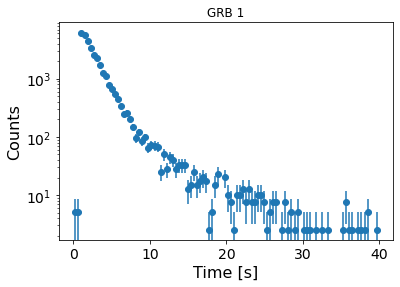

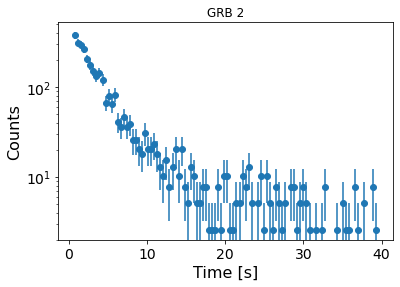

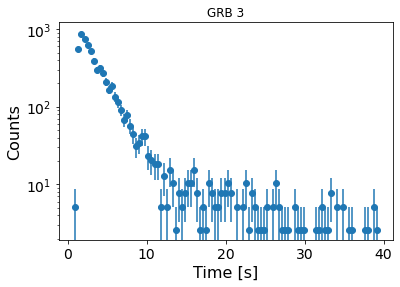

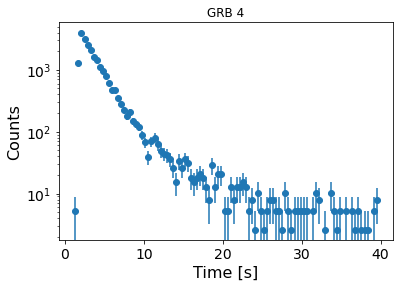

In [20]:
times1, t_counts1, t_edges1 = plot_time_profile(1, grb1)
times2, t_counts2, t_edges2 = plot_time_profile(2, grb2)
times3, t_counts3, t_edges3 = plot_time_profile(3, grb3)
times4, t_counts4, t_edges4 = plot_time_profile(4, grb4)

Here we see that the data look like an exponential at first, with some start time $t_0$. Therefore I will create such a function and fit it by minimizing the Poisson LogLikelihood. The reason why I minimize the Poisson LL and not $\chi^2$ is that I don't want to rebin the data, since this could decrease the accuracy of the start time $t_0$. For the errors on the minimization I will define a $1-\sigma$ interval, as the process that is being measured here is not well understood.

In [21]:
def model_int_cf(ecent, ebins, model, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.'''
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

def exp_model(t, *parm):
    '''Model with one exponential curve, with cutoff t_0.'''
    t_0    = parm[0]
    N_01   = parm[1]
    Norm1  = parm[2]
    
    y = np.where(t < t_0, 0, Norm1 * np.exp(-t/N_01))
    return y + 0.01*190/0.397774

In [22]:
def fit_time_profile(model, t_counts, t_edges, *parm, number):
    '''Fits the time profile with given model. Method of fit is minimization of the Poisson integrated LogLikelihood.'''
    bwidths  = np.diff(t_edges)
    cDen     = t_counts/bwidths
    cDen_err = np.sqrt(t_counts)/bwidths
    times    = (t_edges[:-1]+t_edges[1:])/2.
    
    result = spopt.minimize(LogLikelihood_Pois_Integ, *parm, args=(model, t_edges, t_counts), method='BFGS')

    best_model = model_int_cf(times, t_edges, model, *result.x)
    best_parms = result.fun
    err = np.sqrt(np.diag(result.hess_inv))
    print("t_0  = ", result.x[0], "+/-", err[0])
    print("N_0  = ", result.x[1], "+/-", err[1])
    print("Norm = ", result.x[2], "+/-", err[2])
    if len(result.x) == 5:
        print("N_02  = ", result.x[3], "+/-", err[3])
        print("Norm2 = ", result.x[4], "+/-", err[4])
    print("Minimum log-likelihood = ", result.fun)
    
    # Plot data and model, with residuals
    plot_spec_model(t_edges, cDen, cDen_err, best_model, number=number)
    return result.x, err, result.fun

t_0  =  0.8776749375527111 +/- 0.007119563394644228
N_0  =  1.8221203814080251 +/- 0.0058037820482916246
Norm =  11657.234359459742 +/- 0.009100144413698575
Minimum log-likelihood =  344.2851559848895


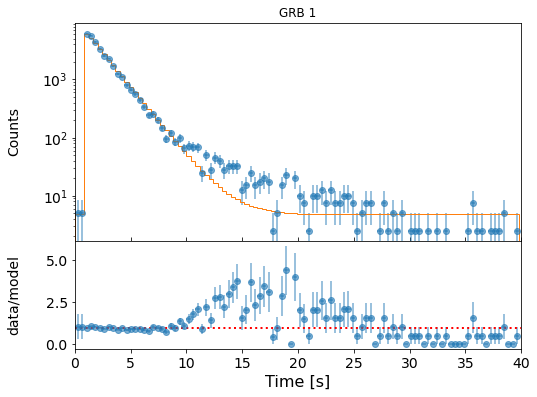

t_0  =  0.02 +/- 1.0
N_0  =  2.8997722146480096 +/- 0.09330436275719593
Norm =  462.82488785797096 +/- 0.10197578939709828
Minimum log-likelihood =  205.5222372478206


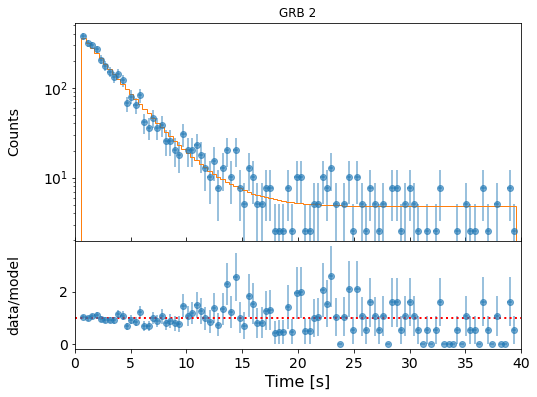

t_0  =  1.332395353027831 +/- 0.011772476288881282
N_0  =  2.220323618481631 +/- 0.04238621223673298
Norm =  1864.6240994149614 +/- 0.03495356292613286
Minimum log-likelihood =  202.99221238648016


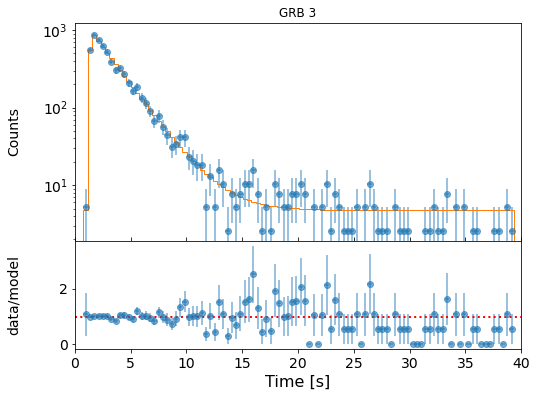

t_0  =  1.780162539933144 +/- 0.01704150358664735
N_0  =  2.0701538644199546 +/- 0.002003054773514652
Norm =  9999.99946517233 +/- 0.040416137685501355
Minimum log-likelihood =  309.7537909460092


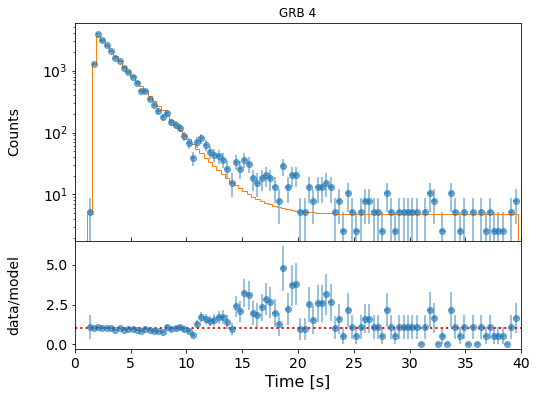

In [23]:
model = exp_model
p01 = [0.88, 1.786, 12041]
p02 = [0.02, 2.3, 460]
p03 = [1.2, 1.41, 1530]
p04 = [1.8, 2.07, 10000]

se_best_parms1, se_errs1, se_minLL_1 = fit_time_profile(model, t_counts1, t_edges1, p01, number=1)
se_best_parms2, se_errs2, se_minLL_2 = fit_time_profile(model, t_counts2, t_edges2, p02, number=2)
se_best_parms3, se_errs3, se_minLL_3 = fit_time_profile(model, t_counts3, t_edges3, p03, number=3)
se_best_parms4, se_errs4, se_minLL_4 = fit_time_profile(model, t_counts4, t_edges4, p04, number=4)

*Conclusions:* From the above figures, we can see that, although the exponential function with the start-time $t_0$ does approximate the distribution of counts, the process is not entirely described by this function. Expecially for GRBs 1 and 4, we can see that the model underestimates the number of counts at around $t=10$ seconds. There seems to be a second exponential, with a smaller slope, that takes over in this region. Thus I will add a second exponential to the model and fit again.

*Approach:* Create a model function with two exponential components and fit as done previously. I use the previously obtained coefficients as my p0. Include background (total energy and binwidths for total bckg per bin)

In [24]:
def double_exp_model(t, *parm):
    '''Model with two exponential curves, with cutoff t_0.'''
    t_0    = parm[0]
    N_01   = parm[1]
    Norm1  = parm[2]
    N_02   = parm[3]
    Norm2  = parm[4]
    
    y1 = np.where(t < t_0, 0, Norm1/N_01 * np.exp(-(t-t_0)*N_01))
    y2 = np.where(t < t_0, 0, Norm2/N_02 * np.exp(-(t-t_0)*N_02))
    return y1 + y2 + 0.01*190/0.397774

t_0  =  0.9124522290245342 +/- 0.006653249339238026
N_0  =  0.6572883594017792 +/- 0.0032846760566403854
Norm =  5004.999958635314 +/- 0.0846270331538272
N_02  =  0.22263654863079163 +/- 0.00376136485499775
Norm2 =  80.30005749650303 +/- 0.014375626082218713
Minimum log-likelihood =  251.72364519944483


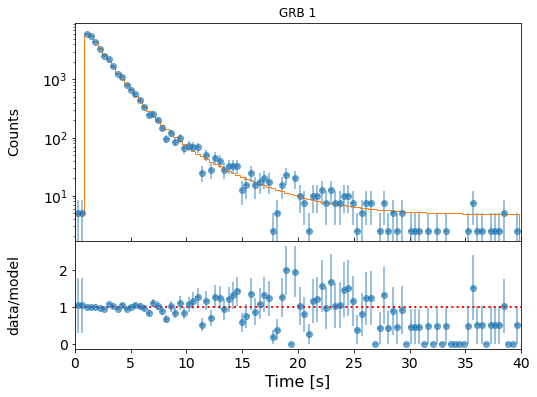

t_0  =  0.6037518202867272 +/- 0.09333264631719401
N_0  =  0.48619402428746666 +/- 0.017514554440612364
Norm =  153.00272734198097 +/- 0.24397599567782935
N_02  =  0.2225834127732558 +/- 0.03280652053345468
Norm2 =  22.891846623332825 +/- 0.1580486580397376
Minimum log-likelihood =  202.14840684910158


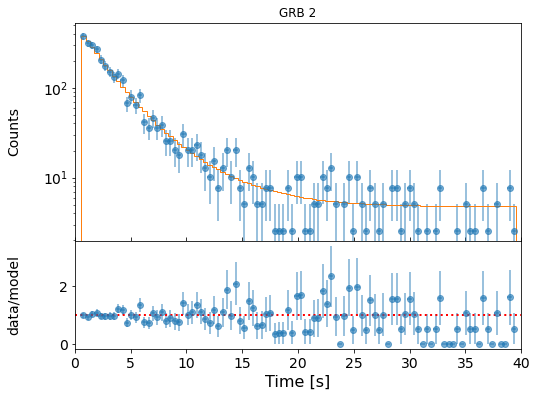

t_0  =  1.341794783591702 +/- 0.01593364475106518
N_0  =  1.1287762517945252 +/- 0.2705033842927168
Norm =  156.23999353573456 +/- 1.392531685077989
N_02  =  0.4353360693799998 +/- 0.006141974882175
Norm2 =  407.7000374711847 +/- 0.4442962916408736
Minimum log-likelihood =  202.60473251551335


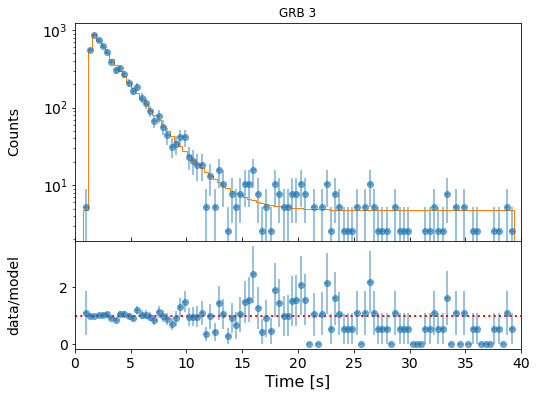

t_0  =  1.790555349331693 +/- 0.004394200236918281
N_0  =  0.5773886486195005 +/- 0.0031474947084219997
Norm =  2544.000296790766 +/- 0.056193157884509834
N_02  =  0.1922698840203228 +/- 0.003955503795805578
Norm2 =  44.61977600372078 +/- 0.147591067937486
Minimum log-likelihood =  241.3621673392168


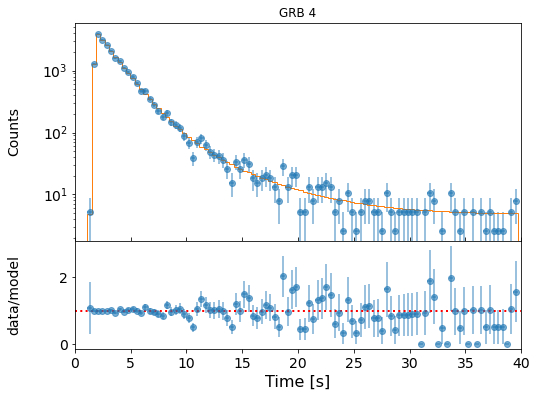

In [25]:
model = double_exp_model

p01 = [0.913, 0.6573, 5005, 0.2226, 80.3]
p02 = [0.605, 0.486, 153, 0.2226, 22.89]
p03 = [1.342, 1.129, 156.24, 0.435, 407.7]
p04 = [1.791, 0.5774, 2544, 0.192, 44.62]

de_best_parms1, de_errs1, de_minLL_1 = fit_time_profile(model, t_counts1, t_edges1, p01, number=1)
de_best_parms2, de_errs2, de_minLL_2 = fit_time_profile(model, t_counts2, t_edges2, p02, number=2)
de_best_parms3, de_errs3, de_minLL_3 = fit_time_profile(model, t_counts3, t_edges3, p03, number=3)
de_best_parms4, de_errs4, de_minLL_4 = fit_time_profile(model, t_counts4, t_edges4, p04, number=4)

*Conclusions:* The fits seem to go more nicely through the data points, especially for GRBs 1 and 4. The minimum log-likelihoods are lower than with the single exponential fit for these two GRBs. For GRBs 2 and 3 the fits are only marginally better. To quantify the improvement, we can see the change in the fit statistic, $\Delta\chi^2=2\Delta LL$, for each GRB, and once again apply Wilks' theorem. The null hypothesis, $H_0$, states that the new, more constrained fit, is not better than the previous one.

$\Delta\chi^2_{GRB1} = 185.12$\
$\Delta\chi^2_{GRB2} = 6.7477$\
$\Delta\chi^2_{GRB3} = 0.77496$\
$\Delta\chi^2_{GRB4} = 136.78$

The $\Delta\chi^2$ are distributed as a $\chi^2_m$ distribution where $m$ is the number of additional constraints. In this case, this corresponds to 2, as only two additional parameters are called in the more constrained double-exponential model. Hence, to get the $p$-values we call the previously defined function, wilks_theorem, and set the df to 2. For GRBs 1 and 4, it is not entirely necessary to use Wilks' theorem, as the improvement in the minimum log-likelihood is large enough to conclude that the constrained fit is better, without the need of further complications. Nevertheless, since the function is already made, I will calculate the $p$-value for them as well. Since the implications of an improvement of the model do not carry great consequences, I will set the minimum $p$-value requirement at a $95\%$ confidence level. 

In [26]:
t_pval1 = wilks_theorem(2*se_minLL_1, 2*de_minLL_1, df=2)
t_pval2 = wilks_theorem(2*se_minLL_2, 2*de_minLL_2, df=2)
t_pval3 = wilks_theorem(2*se_minLL_3, 2*de_minLL_3, df=2)
t_pval4 = wilks_theorem(2*se_minLL_4, 2*de_minLL_4, df=2)

print("p-value for our delta-chi2 on grb1: ",t_pval1)
print("p-value for our delta-chi2 on grb2: ",t_pval2)
print("p-value for our delta-chi2 on grb3: ",t_pval3)
print("p-value for our delta-chi2 on grb4: ",t_pval4)

p-value for our delta-chi2 on grb1:  6.324797557052197e-41
p-value for our delta-chi2 on grb2:  0.03425816328043389
p-value for our delta-chi2 on grb3:  0.6787652970030938
p-value for our delta-chi2 on grb4:  1.9856159793009616e-30


*Conclusions:* As expected, for the first and last GRBs, the $p$-value is extremely small, pointing to the fact that the doouble-exponential fit is much better than the single exponential. For GRB 2, the null hypothesis $H_0$ can be ruled out at  the required $95\%$ confidence level, even though the result is not as certain as for GRBs 1 and 4. Lastly, for GRB3, $H_0$ cannot be rejected at the $95\%$ confidence level, as the fit quality improved only slightly. Thus, the addition of a second exponential to the model proved to be significant for GRBs 1, 2 and 4, and insignificant for GRB 3 at the $95\%$ confidence level.

*NB.* No Bonferroni correction was applied this time, as we're not comparing the addition of a highly specific feature to the model.

## 4. Time-dependence of energy profile

*Approach:* In order to see the time-dependence of the energy profile, I will plot a 2d histogram with energy on the x-axis and time on the y-axis. 

In [27]:
def hist_2d(grb, number, plot_flag=False):
    '''Plot a 2d histogram of the GRB burst with time on the y-axis and energy on the x-axis.'''
    densities, xedges, yedges = np.histogram2d(grb[:,0], grb[:,1], bins=150, density=True)
#     densities = np.where(densities==0, 9e-10, densities)
    
    xgrid, ygrid = np.meshgrid((xedges[1:]+xedges[:-1])/2, (yedges[1:]+yedges[:-1])/2, indexing='ij')
    if plot_flag:
        fig, ax = plt.subplots(figsize=(8,6))
        color_m = ax.pcolormesh(ygrid, xgrid, densities, norm=colors.LogNorm(vmax=densities.max()))
        ax.set_title(f'GRB {str(number)}')
        ax.set_xlabel('Energy [GeV]')
        ax.set_ylabel('Time [s]')
        ax.set_xscale('log')
        ax.set_ylim(0,40)
        # ax.set_yscale('log')

        cbar = fig.colorbar(color_m, ax=ax, extend='min')
        cbar.set_label('Counts', rotation=270)
        plt.show()
    else:
        return xgrid, ygrid, densities

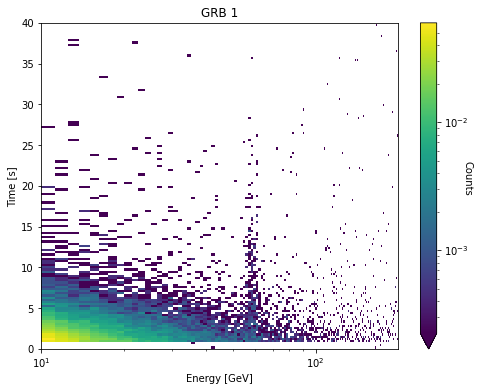

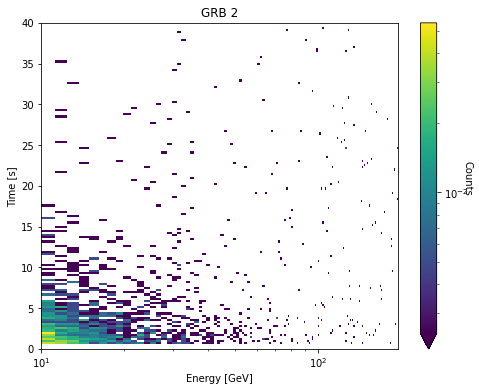

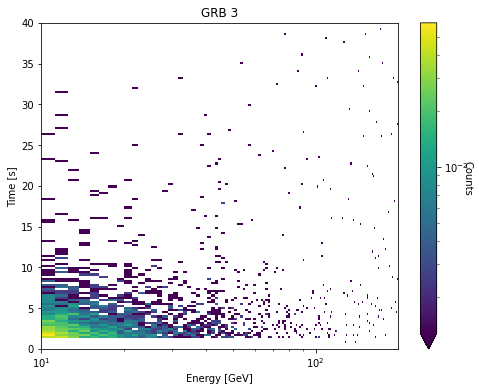

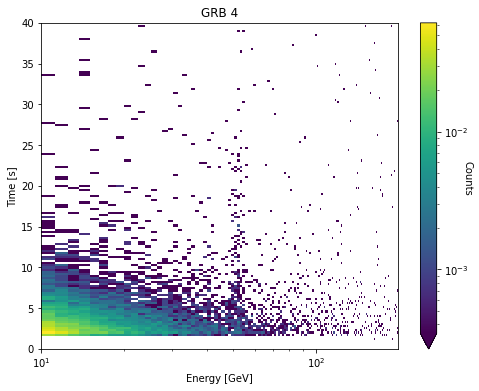

In [28]:
hist_2d(grb1, number=1, plot_flag=True)
hist_2d(grb2, number=2, plot_flag=True)
hist_2d(grb3, number=3, plot_flag=True)
hist_2d(grb4, number=4, plot_flag=True)

*Conclusions:* From these 2d histograms, we can conclude a couple of things. Firstly, we see the time delay between the event, and the first counts coming in, as a horizontal gap in the bottom of the graphs. Secondly, we see (not really in the case of GRB 2) the emission line analyzed earlier. The counts here seem to come for a longer time than at other energies. In order to see whether the photons from the emission line arrive throughout the whole event, I can cut the data, and fit the power law+gaussian over the first half and the second half of the data.

*Approach:* I split the grb data into two at the median. The median was chosen after trying to place the cut at various different positions, and it gave the most interesting results. Furthermore, since the number of counts is equal in the set before and after the cut, comparing the two is relatively easy.

In [29]:
# redefine bin integration function for gaussian_pl model
def model_int_cf(ebins, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.'''
    i = 0
    ymod = np.zeros(len(ebins)-1)
    model = gaussian_pl
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm), ebins[i], ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

In [30]:
def double_energy_hist(grb, mincounts=20, plot_flag=False):
    '''Splits GRB data set on the median, and plots rebinned energy density histogram.'''
    grb_early = grb[:len(grb)//2]
    grb_late  = grb[len(grb)//2:]

    en_counts_early, en_edges_early = np.histogram(grb_early[:,1], bins=100, range=[10,200], density=False)
    en_counts_early, en_edges_early = histrebin(mincounts, en_counts_early, en_edges_early)
    en_counts_late, en_edges_late   = np.histogram(grb_late[:,1], bins=100, range=[10,200], density=False)
    en_counts_late, en_edges_late   = histrebin(mincounts, en_counts_late, en_edges_late)
    
    bwidths_early = np.diff(en_edges_early)
    bwidths_late  = np.diff(en_edges_late)

    en_bins_early = (en_edges_early[:-1]+en_edges_early[1:])/2.
    en_bins_late  = (en_edges_late[:-1]+en_edges_late[1:])/2.
    cdens_early = en_counts_early/bwidths_early
    cdens_late  = en_counts_late/bwidths_late
    cdens_err_early = np.sqrt(en_counts_early)/bwidths_early # 1-sigma error is sqrt(counts)
    cdens_err_late  = np.sqrt(en_counts_late)/bwidths_late
    if plot_flag:
        plt.figure(figsize=(7,4))
        plt.errorbar(en_bins_early, cdens_early, xerr=bwidths_early/2., yerr=cdens_err_early, fmt='o', label='Early')
        plt.errorbar(en_bins_late, cdens_late, xerr=bwidths_late/2., yerr=cdens_err_late, fmt='o', label='Late')
        plt.yscale('log')
        plt.xscale('log')
        plt.title('Energy distribution for GRB event')
        plt.xlabel('Energy [GeV]')
        plt.ylabel('Count density [GeV$^{-1}$]')
        plt.legend()
        plt.show()
    return [en_bins_early, en_edges_early, cdens_early, cdens_err_early],\
           [en_bins_late, en_edges_late, cdens_late, cdens_err_late]

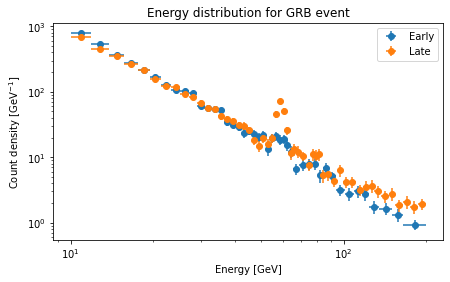

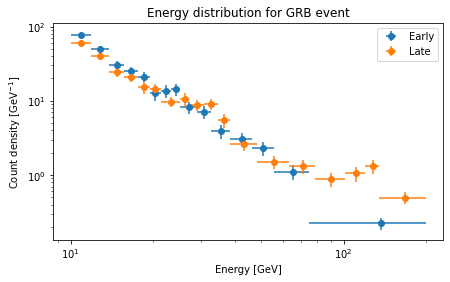

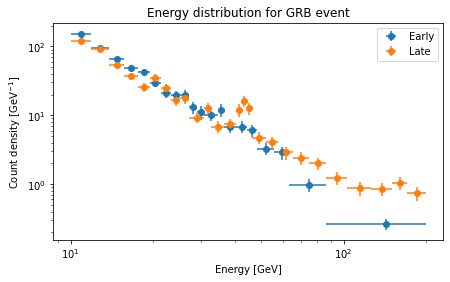

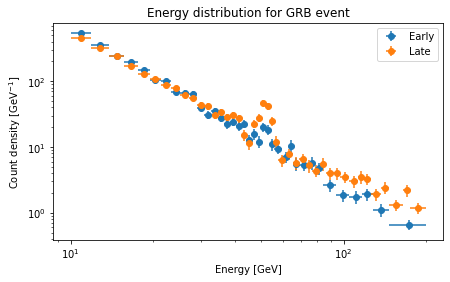

In [31]:
data_early1, data_late1 = double_energy_hist(grb1, plot_flag=True)
data_early2, data_late2 = double_energy_hist(grb2, plot_flag=True)
data_early3, data_late3 = double_energy_hist(grb3, plot_flag=True)
data_early4, data_late4 = double_energy_hist(grb4, plot_flag=True)

*Conclusion:* Here we very clearly see that the emission burst happens int the later part of the GRB. To quantify this change, I will fit the power law and gaussian used earlier.

In [32]:
def fit_double_pl(data_early, data_late, p0_early, p0_late):
    '''Fit powerlaw and plot the results, printing the coefficients obtained, and returning minimum chi2.'''
    # calculate histogram values of grb data
    en_bins_early, en_edges_early, cdens_early, cdens_err_early = data_early
    en_bins_late, en_edges_late, cdens_late, cdens_err_late = data_late
    bwidths_early = np.diff(en_edges_early)
    bwidths_late  = np.diff(en_edges_late)

    # fit pl+gaussian model to the data
    ml_cfpars_early, ml_cfcovar_early = spopt.curve_fit(lambda en_bins_early, *parm: model_int_cf(en_edges_early, *parm),
                                                        en_bins_early, cdens_early, p0_early, sigma=cdens_err_early)
    ml_cfpars_late, ml_cfcovar_late = spopt.curve_fit(lambda en_bins_late, *parm: model_int_cf(en_edges_late, *parm),
                                                      en_bins_late, cdens_late, p0_late, sigma=cdens_err_late)
    # print fit results
    err = np.sqrt(np.diag(ml_cfcovar_early))
    print("Fit parameters of early half of the GRB: \n",
    "------------------------------------------------------")
    print("N_0    = " + str(ml_cfpars_early[0]) + " +/- " + str(err[0]))
    print("Gamma  = " + str(ml_cfpars_early[1]) + " +/- " + str(err[1]))
    print("N_tot  = " + str(ml_cfpars_early[2]) + " +/- " + str(err[2]))
    print("E_cent = " + str(ml_cfpars_early[3]) + " +/- " + str(err[3]))
    minchisq_early = np.sum(((cdens_early - model_int_cf(en_edges_early, *ml_cfpars_early))/cdens_err_early)**2.)
    print("Minimum Chi-squared = " + str(minchisq_early) + " for " + str(len(cdens_early)-len(ml_cfpars_early)) + " d.o.f.")
    print("The goodness of fit is: " + str(sps.chi2.sf(minchisq_early,df=(len(cdens_early)-len(ml_cfpars_early)))),'\n')
    err = np.sqrt(np.diag(ml_cfcovar_late))
    print("Fit parameters of late half of the GRB: \n",
    "------------------------------------------------------")
    print("N_0    = " + str(ml_cfpars_late[0]) + " +/- " + str(err[0]))
    print("Gamma  = " + str(ml_cfpars_late[1]) + " +/- " + str(err[1]))
    print("N_tot  = " + str(ml_cfpars_late[2]) + " +/- " + str(err[2]))
    print("E_cent = " + str(ml_cfpars_late[3]) + " +/- " + str(err[3]))
    minchisq_late = np.sum(((cdens_late - model_int_cf(en_edges_late, *ml_cfpars_late))/cdens_err_late)**2.)
    print("Minimum Chi-squared = " + str(minchisq_late) + " for " + str(len(cdens_late)-len(ml_cfpars_late)) + " d.o.f.")
    print("The goodness of fit is: " + str(sps.chi2.sf(minchisq_late,df=(len(cdens_late)-len(ml_cfpars_late)))))
    
    # plot data + fit
    cdens_model_early = model_int_cf(en_edges_early, *ml_cfpars_early)
    cdens_model_late  = model_int_cf(en_edges_late, *ml_cfpars_late)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,5),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(en_bins_early, cdens_early, xerr=bwidths_early/2., yerr=cdens_err_early, fmt='o', label='Early', alpha=0.6)
    ax1.errorbar(en_bins_late, cdens_late, xerr=bwidths_late/2., yerr=cdens_err_late, fmt='o', label='Late', alpha=0.6)
    ax1.hist(en_bins_early, bins=en_edges_early, weights=cdens_model_early, density=False, histtype='step', lw=1.5)
    ax1.hist(en_bins_late, bins=en_edges_late, weights=cdens_model_late, density=False, histtype='step', lw=1.5)
    
    ax2.errorbar(en_bins_early, cdens_early/cdens_model_early, xerr=bwidths_early/2.,
                 yerr=cdens_err_early/cdens_model_early, fmt='o', alpha=0.6)
    ax2.errorbar(en_bins_late, cdens_late/cdens_model_late, xerr=bwidths_late/2.,
                 yerr=cdens_err_late/cdens_model_late, fmt='o', alpha=0.6)

    ax2.set_xlabel("Energy (GeV)", fontsize=16)
    ax1.set_ylabel("Counts/Gev", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(10,200)
    ax1.legend()
    plt.show()

Fit parameters of early half of the GRB: 
 ------------------------------------------------------
N_0    = 294483.9937805644 +/- 18612.764117916417
Gamma  = 2.4790924228263913 +/- 0.02131432727123493
N_tot  = 45.157378232396084 +/- 11.527402750715567
E_cent = 58.85189679697955 +/- 0.729420195642858
Minimum Chi-squared = 36.601030118990714 for 40 d.o.f.
The goodness of fit is: 0.624069032658832 

Fit parameters of late half of the GRB: 
 ------------------------------------------------------
N_0    = 171005.6295162706 +/- 10824.70500218392
Gamma  = 2.309223324137189 +/- 0.02089828105483467
N_tot  = 273.8033053540545 +/- 19.816034759819424
E_cent = 58.81673056636287 +/- 0.17167208852644286
Minimum Chi-squared = 44.96572622481733 for 48 d.o.f.
The goodness of fit is: 0.5979286464614607


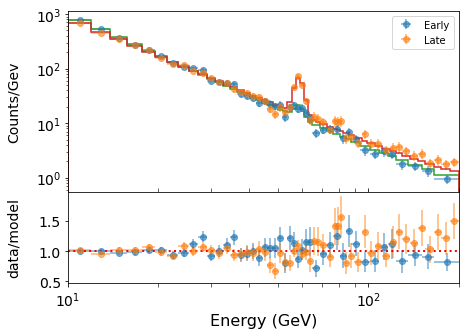

Fit parameters of early half of the GRB: 
 ------------------------------------------------------
N_0    = 83752.03106748877 +/- 61491.87248605661
Gamma  = 2.908282626436372 +/- 0.2709188594822526
N_tot  = 20.417559487403103 +/- 19.499326255493415
E_cent = 29.473028724302193 +/- 2.5372769482955353
Minimum Chi-squared = 53.6097955416448 for 11 d.o.f.
The goodness of fit is: 1.3904324807133233e-07 

Fit parameters of late half of the GRB: 
 ------------------------------------------------------
N_0    = 12306.903252909924 +/- 3122.8399223898105
Gamma  = 2.2637885910751834 +/- 0.08600437709967829
N_tot  = 26.33401943813819 +/- 8.680864796470711
E_cent = 32.18685318362989 +/- 1.0605974284022115
Minimum Chi-squared = 13.391459283749493 for 14 d.o.f.
The goodness of fit is: 0.49595763444188756


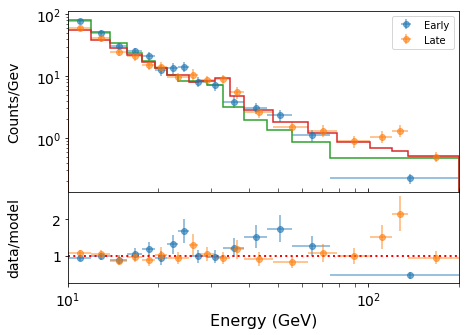

Fit parameters of early half of the GRB: 
 ------------------------------------------------------
N_0    = 132968.61183329346 +/- 51613.308740020766
Gamma  = 2.8195054848368564 +/- 0.13942296677303273
N_tot  = 24.635389819600068 +/- 15.035591388528871
E_cent = 44.163675988003384 +/- 1.6294885576482576
Minimum Chi-squared = 60.67647484975983 for 16 d.o.f.
The goodness of fit is: 4.024105567695304e-07 

Fit parameters of late half of the GRB: 
 ------------------------------------------------------
N_0    = 26040.51349852947 +/- 5481.350430897294
Gamma  = 2.279739853288003 +/- 0.07056670511067407
N_tot  = 56.04303796930449 +/- 12.427138951271104
E_cent = 43.45308119503526 +/- 0.5772318455340403
Minimum Chi-squared = 30.77247065881137 for 22 d.o.f.
The goodness of fit is: 0.10086617686306994


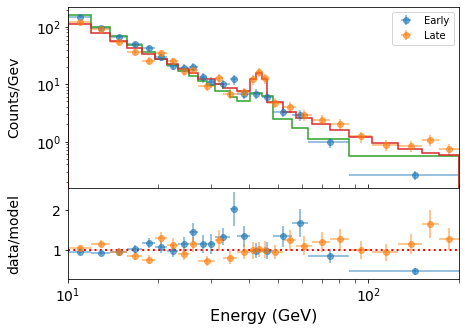

Fit parameters of early half of the GRB: 
 ------------------------------------------------------
N_0    = 231121.78272842467 +/- 21628.5504886458
Gamma  = 2.5343609365365225 +/- 0.03191714009019195
N_tot  = 39.226946583814566 +/- 13.090528126732483
E_cent = 51.99605222451572 +/- 0.8452095618446027
Minimum Chi-squared = 41.718994166299034 for 33 d.o.f.
The goodness of fit is: 0.1419582251195059 

Fit parameters of late half of the GRB: 
 ------------------------------------------------------
N_0    = 112700.1554839773 +/- 9589.37482595471
Gamma  = 2.304292201467349 +/- 0.028155222787951517
N_tot  = 179.00427203637403 +/- 18.386321525918977
E_cent = 51.654047728237394 +/- 0.2549296716012249
Minimum Chi-squared = 43.50466428719819 for 39 d.o.f.
The goodness of fit is: 0.2855206428858258


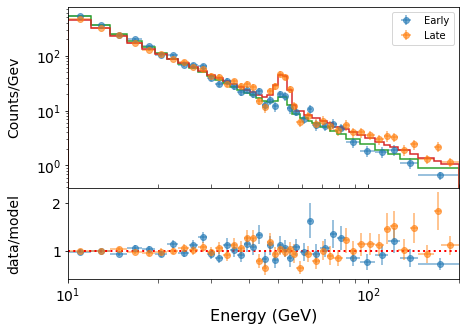

In [33]:
fit_double_pl(data_early1, data_late1, [359000, 2.31, 50, 60], [359000, 2.31, 50, 60])
fit_double_pl(data_early2, data_late2, [19100, 2.12, 10, 30], [19100, 2.12, 10, 30])
fit_double_pl(data_early3, data_late3, [52000, 2.24, 50, 40], [52000, 2.24, 50, 40])
fit_double_pl(data_early4, data_late4, [242970, 2.31, 50, 50], [242970, 2.31, 50, 50])

*Conclusion:* Here we see clearly that the emission line appears in the later stages of the burst event. We see in all four GRBs that the size of the line $N_{tot}$ increases in the second half significantly. Furthermore, it seems that the higher energy photons arrive later than the low energy photons. The slope of the exponential shrinks in in the late set for all cases. This can be seen in that the fit for the early set is always below the fit for the late set in the high-energy range.